# 期中大作业-模型压缩与对抗

负责助教：李世成、郭明非

截止时间：5月14日（建议有基础的同学尽量5月9日前提交，可获得被选中讲评加分的机会）

**4月30日更新**
1. 补充完善了动态阈值的量化激活函数的说明（方案说明与之前有细微差别，如果已经按照之前的说明实现，并且能够达成增强模型鲁棒性的目标，则不需要改为当前方案，在报告中说明即可）；
2. 微调了作业要求部分的分数分配，补充了可供参考的分析实验；
3. 更新了参考结果。

## A 概述
本次作业主要内容为：在CIFAR10图像分类数据集上训练卷积神经网络，使用PGD对网络进行对抗攻击，并尝试对抗训练、模型压缩和参数正则化三种防御策略。

## B 背景知识

### (i) 对抗攻击
神经网络在图片分类任务上取得了很高的准确率，但研究表明它们的鲁棒性往往很差。通过对输入图片进行一个微小的扰动，可以在不影响图片视觉效果的前提下，让神经网络的分类准确率大幅下降。这种对模型进行攻击的方式称为**对抗攻击**，对应的扰动后的图片称为**对抗样本**。

根据模型是否可见，对抗攻击可以分为
- 白盒攻击（white-box attack）：攻击者知道模型的内部结构与参数，可以对输入数据求梯度来寻找对抗样本。
- 黑盒攻击（black-box attack）：攻击者不知道模型的内部结构与参数，仅可以调用模型获取对于给定输入的输出结果。

根据是否指定攻击后的分类类别，对抗攻击又可以分为
- 指向性攻击（targeted attack）：使模型将扰动后的输入分类为指定的错误类别。
- 非指向性攻击（untargeted attack）：使模型将扰动后的输入分类为任一错误类别。

本次大作业，我们主要研究白盒非指向性攻击和对应的防御策略。

大多数白盒攻击算法基于模型关于输入的梯度对输入进行扰动。这些算法将对抗攻击转化为求解这样一个优化问题：给定扰动量的限制$\epsilon$，最大化扰动后的损失函数$\mathcal{L}(x,y;\theta)$。例如，Fast Gradient Sign Method (FGSM) 沿着梯度的$l_{\infty}$范数方向进行一步扰动
$$x' = x + \epsilon \cdot \mathrm{sign}(\nabla_x \mathcal{L}(x,y;\theta))$$
Projected Gradient Descent (PGD) 可以看作是FGSM的多步迭代版本，其攻击方法为
$$x'_{t+1} = \mathrm{Clip}_{x,\epsilon}(x'_t + \alpha \cdot \mathrm{sign}(\nabla_x \mathcal{L}(x'_t,y;\theta))$$
其中$\mathrm{Clip}$操作限制扰动的无穷范数不超过$\epsilon$。

### (ii) 对抗训练
一种简单而有效的对抗防御方法是直接将对抗样本作为一种数据增广的方式加入到训练过程中。考虑PGD的攻击方式，根据[这篇论文](https://arxiv.org/abs/1706.06083)，如果我们训练⼀个网络对PGD具有鲁棒性，那么它对各种其他攻击也具有鲁棒性。本次作业要求实现基于PGD的对抗训练。

### (iii) 模型压缩
模型压缩通常分为以下几个类别：
 
    Pruning 剪枝，去掉模型中作用比较小的连接。
    Quantization 量化，降低大模型的精度来减小模型，如将32bit的参数量化成8bit的参数。
    Low-rank approximation and sparsity 低秩稀疏近似，通过组合较少的参数来近似一个层的大量冗余参数。
    Knowledge distillation 蒸馏，用大模型的学到的知识训练小模型，从而让小模型具有大模型的能力。

以量化到8bit为例：

    矩阵matrix可以用scale * matrix_integer近似计算出来，其中scale是一个浮点数，matrix_integer是一个由-128 ～ 127的整数组成的矩阵。
    这样matrix_integer中的每一个数都可以用8位来表示。
    
    首先，需要计算矩阵的scale。对于8bit量化，可以将scale认为是矩阵绝对值中的最大值除以2^(8-1)-1。然后将原始矩阵matrix除以scale，之后round成整数，并限制在-128 ～ 127内，这样就得到了matrix_integer。也就完成了量化过程。


可以在对抗训练过程中将网络量化到8bit。
当对抗样本中包含的扰动非常小时，量化模型的低精度有助于去掉样本中的扰动，获得更好的鲁棒性。

但是，按照上一个例子，不同量化的阈值是通过权重矩阵绝对值中的最大值决定的，并且是均匀分布的。
这种均匀分布的阈值不适合权重矩阵里有离群值的情况。
因此可以使用动态量化方法，将不同的量化阈值设定成可学习的参数。

由于输入到下一层的值是直接由激活函数得到的，因此量化激活函数的阈值更加重要。
一个参数为$t_1, t_2, t_3$的2bit动态阈值激活函数的例子如下。

$$f(x)= \begin{cases}0, & \text { if } x<t_{1} \\ t_{1}, & \text { if } t_{1}<x<t_{2} \\ t_{2}, & \text { if } t_{2}<x<t_{3} \\ t_{3}, & \text { if } x>t_{3}\end{cases}$$

由于这里在训练过程中进行了离散化的操作，反向传播过程中可能导致导数几乎处处为零。这里我们可以采取一种被称为[straight-through estimator](https://zhuanlan.zhihu.com/p/72681647)的技术，即在前向传播时使用量化后的值，在反向传播时直接将损失函数对于量化后张量的梯度作为其对量化前张量的梯度，对于上面这个激活函数，其梯度的计算方式为

$$\nabla_x f(x)= \begin{cases}0, & \text { if } x<0 \text { or } x>t_{3} \\ 1, & \text { if } 0<x<t_{3} \end{cases}$$

### (iv) 参数正则化
函数$f(x)$的[李普希茨常数](https://zhuanlan.zhihu.com/p/389024283)定义为这样的一个常数$l$，使得$\forall x_1, x_2$，都有
$$\lVert f(x_1) - f(x_2) \rVert \leq l \lVert x_1 - x_2 \rVert$$
如果一个神经网络$f_{\Theta}(x)$的李普希茨常数较小，则意味着当输入的改变量较小时，模型输出的改变量也不会太大，因此模型往往具有更好的鲁棒性。
从这个角度出发，我们可以通过参数正则化的方法限制神经网络中的李普希茨常数$l$，以构建更鲁棒的机器学习模型。

下面我们考虑如何计算神经网络的李普希茨常数。首先讨论当$f(x)$是线性的时候，设$f(x)=Wx+b$，则有
$$\lVert f(x_1) - f(x_2) \rVert_2 = \lVert (Wx_1+b) - (Wx_2+b) \rVert_2 = \lVert W(x_1-x_2) \rVert_2 \leq \lVert W \rVert_2 \lVert x_1 - x_2 \rVert_2$$
因此$l=\lVert W \rVert_2$是矩阵$W$的谱范数，等于其最大奇异值$\sigma_1(W)$。

接下来讨论$f(x)$是一个以ReLU为激活函数的多层全连接网络时，设$f = f^L \circ f^{L-1} \circ \cdots \circ f^1$，其中$f^i(x) = \mathrm{ReLU}(W^i x+b^i)$。由于
$$\lVert \mathrm{ReLU}(x_1) - \mathrm{ReLU}(x_2) \rVert \leq \lVert x_1 - x_2 \rVert$$
因此
$$\lVert f(x_1) - f(x_2) \rVert \leq \prod_{i=1}^L \sigma_1(W^i) \cdot \lVert x_1 - x_2 \rVert$$

由于卷积运算也是线性变换，因此可以得到类似的结论。从而对于全连接网络和卷积神经网络，我们只需要对于其中的权重参数的谱范数加入一个惩罚项，就可以实现减小网络李普希茨常数的效果。

对于权重矩阵$W$，本次大作业我们考虑如下两种正则化方式。

#### a) 正交正则化
由于正交矩阵的奇异值都为1，可以加入如下正则化项鼓励$W$为（列）正交矩阵
$$\mathcal{L} = \mathcal{L}_{\mathrm{CE}}+\frac{\lambda}{2}\sum_i \lVert (W^i)^T W^i-I \rVert^2$$
其中$\mathcal{L}_{\mathrm{CE}}$为交叉熵损失函数，$\lambda$为控制正则化强度的超参数。在这里我们暂时将卷积层中的参数矩阵$W$按照与线性层相似的方式正则化，在b)中我们将考虑一种更加严谨的做法。

#### b) 谱范数正则化
首先回顾一下奇异值分解。对于任意实矩阵$W \in \mathbb{R}^{m\times n}$，可以将其分解为$W=U\Sigma V^T$，其中
- $U \in \mathbb{R}^{n \times k}$且$UU^T=I_n$
- $V \in \mathbb{R}^{m \times k}$且$VV^T=I_m$
- $\Sigma \in \mathbb{R}^{k \times k}$, $\Sigma = \mathrm{diag}(\sigma_1, \sigma_2, \cdots, \sigma_k)$且$\sigma_1 \ge \sigma_2 \ge \cdots \ge \sigma_k > 0$

当$W$对应于最大奇异值的左、右奇异向量分别为$u_1$和$v_1$时，有结论$\sigma_0(W)=u_1^TWv_1$和$\nabla_W \sigma_0(W)=u_1v_1^T$，因此我们也可以直接把谱范数加入正则化项
$$\mathcal{L} = \mathcal{L}_{\mathrm{CE}}+\frac{\lambda}{2}\sum_i \lVert \sigma_1(W^i) \rVert^2$$
其中$\mathcal{L}_{\mathrm{CE}}$为交叉熵损失函数，$\lambda$为控制正则化强度的超参数。

这一正则化方式对于线性层可以直接对权重矩阵计算得到，但是对于卷积层，比较严谨的做法是将卷积操作看成一个输入大小为**输入通道数\*输入高度\*输入宽度**、输出大小为**输出通道数\*输出高度\*输出宽度**的线性层，如果求出对应的矩阵再进行奇异值分解会消耗大量时间和空间。这里我们可以使用幂迭代法（power iteration）来求解最大奇异值对应的奇异向量，具体算法为
- 随机初始化向量$\tilde{u}$和$\tilde{v}$
- 重复以下过程直至收敛
$$\tilde{v} \leftarrow \frac{W^T\tilde{u}}{\lVert W^T\tilde{u} \rVert_2}, \tilde{u} \leftarrow \frac{W\tilde{v}}{\lVert W\tilde{v} \rVert_2}$$
这里对于卷积层，事实上并不需要计算出$W$，而是可以直接利用卷积操作进行比较高效的操作，请同学们自行思考如何实现。一般情况下，幂迭代法都可以在很少的步数内达到收敛，因此不仅可以用于卷积层，也可以加速线性层的正则化项计算。
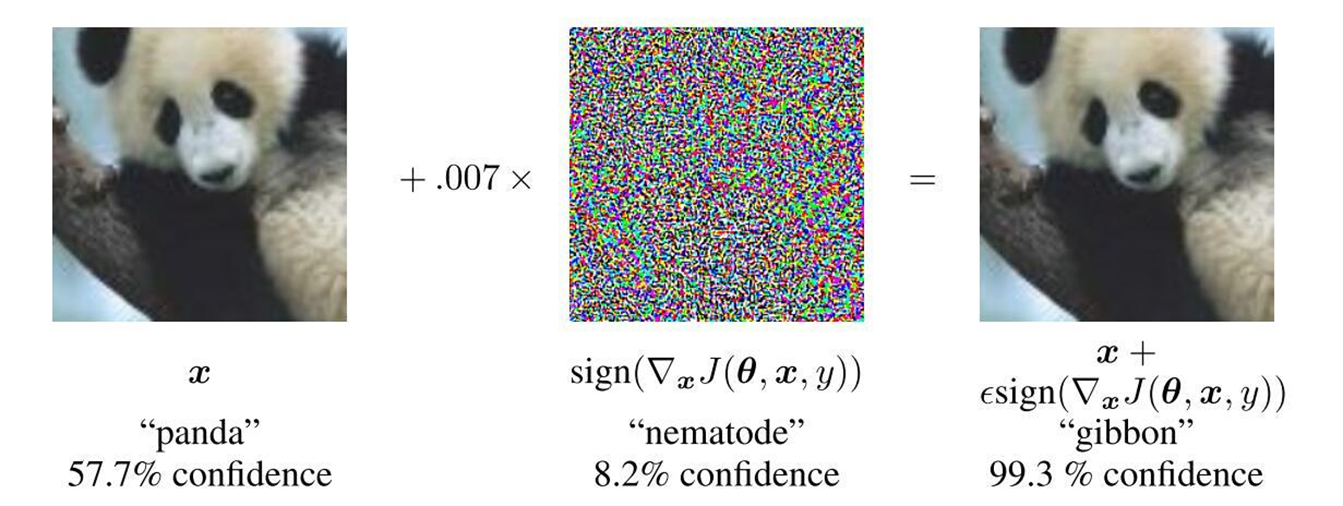

## C 作业要求
#### 基本要求
1. 自己搭建一个以ReLU为激活函数的卷积神经网络，在CIFAR10数据集上进行训练和测试。(5')
2. 实现PGD对抗攻击，在CIFAR10的测试集上对1中得到的模型进行攻击，比较攻击前后的测试准确率，并计算攻击成功率（原模型成功预测的样本中，经过对抗攻击使得模型预测错误的百分比）。在攻击成功的样本中，随机挑选5张，打印攻击前后的图像输入和模型预测类别。(10')
3. 实现B中的三种对抗防御方式：
    - 实现基于PGD的对抗训练；(5')
    - 按照B-(iii)中的模型量化方案，在训练过程中将网络量化到8bit，并且使用动态阈值的激活函数来替代原模型中的ReLU激活函数；(25')
    - 实现B-(iv)中的两种正则化项，其中谱范数正则化项建议同学们采用幂迭代法实现；(25')
4. 撰写报告，说明方案的具体实现过程，通过实验对比分析几种对抗防御方法对模型鲁棒性的影响。参考的分析实验包括：不同模型的测试准确率随PGD的$\epsilon$变化的曲线、通过定量或可视化的方法比较不同训练方法得到网络的平滑程度等。(30')

#### 加分项
本次大作业的加分上限为10分。可选项包括：
- 通过考虑动态阈值的激活函数参数与激活函数值，在输入图像限制在训练集上时，给出李普希茨常数的一个更紧的上界，据此设计正则化项，并通过实验验证其效果；(10')
- 参考[Random Self-ensemble](https://openaccess.thecvf.com/content_ECCV_2018/papers/Xuanqing_Liu_Towards_Robust_Neural_ECCV_2018_paper.pdf)或者[Feature Squeezing](https://arxiv.org/pdf/1704.01155.pdf)，实现一种基于随机化或者去噪方法的对抗防御，并通过实验与本次作业要求的三种方法比较各自的优缺点。(10')

#### 说明
- 上交内容包括源代码与实验报告，打包为"姓名+学号+模型压缩与对抗大作业.zip"提交。
- 加入对抗防御措施后模型的准确率出现小幅度的下降属于正常现象，并且由于数据集较小，部分方法可能不会获得显著的鲁棒性提升。本次作业侧重于算法的理解与实现，不要求投入大量精力调参以追求很高的准确率，对于没有效果的方法可以对其原因进行简单的分析。参考结果（两层卷积神经网络，训练10个epoch，PGD参数为$\epsilon=8/255$, $\alpha=2/255$, 迭代次数为4）：
    - 原始模型：攻击前准确率71%，攻击后准确率24%
    - 加入模型量化后：攻击前准确率71%，攻击后准确率27%
    - 加入模型量化与4bit的动态阈值激活函数后：攻击前准确率72%，攻击后准确率31%
    - 加入对抗训练后：攻击前准确率67%，攻击后准确率44%
    - 加入模型量化、动态阈值激活函数和对抗训练后：攻击前准确率72%，攻击后准确率55%
    - 加入正交正则化（系数0.0001）后：攻击前准确率72%，攻击后准确率26%
    - 加入模型量化、4bit的动态阈值激活函数和谱范数正则化（系数0.001）后：攻击前准确率73%，攻击后准确率35%

## D 代码框架
下面提供了代码框架，仅供同学们参考，同学们可以按照需要进行修改。

In [1]:
import os
import math
import numpy as np
import random

from attrdict import AttrDict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms

In [2]:
# 数据集
class CIFAR10():
    MEAN = (0.485, 0.456, 0.406)
    STD = (0.229, 0.224, 0.225)
    NUM_CLASSES = 10
    IMAGE_SIZE = [32, 32]
    IMAGE_CHANNELS = 3
    
    def __init__(self):
        transform = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize(self.MEAN, self.STD)])
        self.load_dataset(transform)
    
    def load_dataset(self, transform):
        self.trainset = torchvision.datasets.CIFAR10(root="./data", transform=transform, download=True)
        self.testset = torchvision.datasets.CIFAR10(root="./data", train=False, transform=transform, download=True)

In [3]:
# 设置随机种子，保证实验可复现性
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

In [4]:
class DynamicAct(nn.Module):
    # TODO: 实现动态阈值的激活函数
    pass

# TODO: 搭建卷积神经网络
class ConvNet(nn.Module):
    def __init__(self, **kwargs):
        super(ConvNet, self).__init__()
        
    def forward(self, x, quant=False):
        """
            x: 输入图片
            quant: 是否使用模型量化
        """
        pass
    
    # TODO: 计算正则项
    def regularizationTerm(self, reg_type):
        """
            reg_type: orthogonal 正交正则项; spectral 谱范数正则项
        """
        term = 0.0
        if reg_type == "orthogonal":
            pass
        elif reg_type == "spectral":
            pass
        else:
            raise NotImplementedError
        
        return term

In [5]:
# TODO: PGD 对抗攻击
class PGD():
    def __init__(self, model, eps=8 / 255, alpha=2 / 255, steps=4):
        pass
    
    def forward(self, images, labels):
        pass

In [6]:
# TODO: 训练与测试代码
setup_seed(1)